In [60]:
from spine_detector.core import SpineDetectorCore
import numpy as np
from scipy.ndimage import gaussian_filter

In [2]:
core = SpineDetectorCore()

In [18]:
path  = '../test-data/0003/T2_TSE_SAG_384_0002'

In [3]:
core.read_mri_dir('../test-data/0003/T2_TSE_SAG_384_0002')

In [4]:
core.update_segmentation()

{'alpha': 0, 'x': 3, 'y': 3, 'z': 3, 'light': 1, 'k_min': 3, 'k_max': 255, 'grad_degree': 1.8}
Activate segmentation
Start get_gradient
Finished get_gradient in 0:00:00.358882
Start box_filtering_with_gauss
Start get_gradient
Finished get_gradient in 0:00:00.372878
Finished box_filtering_with_gauss in 0:00:00.714767


In [5]:
mask = core.mask_data

In [6]:
import matplotlib.pyplot as plt

{'x': 1, 'y': 5, 'z': 5, 'grad_degree': 1.8}
Activate segmentation
Start get_gradient
Finished get_gradient in 0:00:00.363883
Start box_filtering_with_gauss
Start get_gradient
Finished get_gradient in 0:00:00.373896
Finished box_filtering_with_gauss in 0:00:00.751756


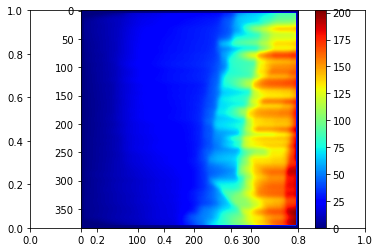

In [15]:
params = {'x': 1, 'y': 5, 'z': 5, 'grad_degree': 1.8}

core.update_segmentation(params)

fig, ax = plt.subplots()
ax = fig.add_subplot()

im = ax.imshow(core.mask_data[6], cmap='jet')
fig.colorbar(im , ax=ax)
plt.show()

In [17]:
from spine_detector.utils import load_mri

In [19]:
data = load_mri(path)

In [54]:
object_3d = np.array([aa.pixel_array for aa in data])
object_3d = object_3d / 4 
object_3d.max()

199.75

In [39]:
def get_gradient2d(data):
    gradient = [np.diff(data, 1, axis=0),
                np.diff(data, 1, axis=1)]
    norm_x = np.zeros_like(data)
    norm_y = np.zeros_like(data)
    
    norm_x[:-1] += gradient[0]
    norm_x[1:] += gradient[0]

    norm_y[:, :-1] += gradient[1]
    norm_y[:, 1:] += gradient[1]
    
    norm = np.sqrt(np.power(norm_x, 2) + np.power(norm_y, 2))
    
    assert not np.argwhere(np.isnan(norm))
    assert np.all(norm >= 0)
    return norm

def get_gradient3d(data, alpha=0):
    gradient = [np.diff(data, 1, axis=0) * alpha,
                np.diff(data, 1, axis=1),
                np.diff(data, 1, axis=2)]
    norm_x = np.zeros_like(data)
    norm_y = np.zeros_like(data)
    norm_z = np.zeros_like(data)

    norm_x[:-1] += gradient[0]
    norm_x[1:] += gradient[0]

    norm_y[:, :-1] += gradient[1]
    norm_y[:, 1:] += gradient[1]

    norm_z[:, :, :-1] += gradient[2]
    norm_z[:, :, 1:] += gradient[2]

    norm = np.sqrt(np.power(norm_x, 2) + np.power(norm_y, 2) + np.power(norm_z, 2))

    assert not np.argwhere(np.isnan(norm))
    assert np.all(norm >= 0)
    return norm
    

In [65]:
def box_filtering2d_with_gauss(data, degree=2, size=(3,3), sigma=2):
    filtered = gaussian_filter(get_gradient2d(data) ** degree, sigma)
    
    csum = np.cumsum(filtered, axis=0)
    csum = np.cumsum(csum, axis=1)

    csum = (csum[2 * size[0]:] - csum[:-2 * size[0]])/(2*size[0] + 1)
    
    csum = (csum[:, 2 * size[1]:] - csum[:, :-2 * size[1]])/(2*size[1] + 1)
    
    csum = np.power(csum, 1/degree)
    
    result = np.zeros_like(data)
    result[size[0]: -size[0], size[1]: -size[1]] = csum 
    
    #result = np.nan_to_num(result)
    assert not np.argwhere(np.isnan(result))
    

    return result

def box_filtering3d_with_gauss(data, degree=2, size=(3, 3, 3), alpha=0, sigma=2):
    gradient = get_gradient3d(data, alpha=alpha) ** degree
    filtered = gaussian_filter(gradient, sigma)

    csum = np.cumsum(filtered, axis=0)
    csum = np.cumsum(csum, axis=1)
    csum = np.cumsum(csum, axis=2)

    csum = (csum[2 * size[0]:] - csum[:-2 * size[0]]) / (2 * size[0] + 1)

    csum = (csum[:, 2 * size[1]:] - csum[:, :-2 * size[1]]) / (2 * size[1] + 1)

    csum = (csum[:, :, 2 * size[2]:] - csum[:, :, :-2 * size[2]]) / (2 * size[2] + 1)

    csum = np.power(csum, 1 / degree)

    result = np.zeros_like(data)
    result[size[0]: -size[0], size[1]: -size[1], size[2]: -size[2]] = csum

    # result = np.nan_to_num(result)
    assert not np.argwhere(np.isnan(result))

    return result

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


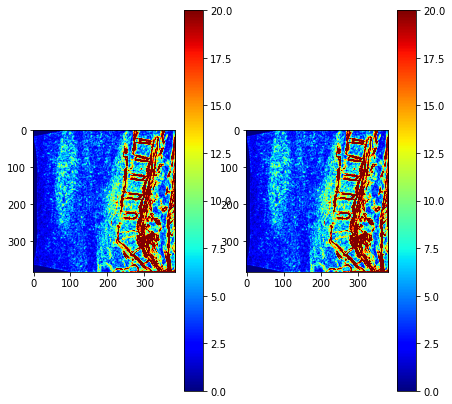

In [56]:
gradient2d = get_gradient2d(object_3d[6])
gradient3d = get_gradient3d(object_3d)[6]

fig, ax = plt.subplots(ncols=2, figsize=(7,7))

im0 = ax[0].imshow(gradient2d, cmap='jet', clim=(0,20))
im1 = ax[1].imshow(gradient3d, cmap='jet', clim=(0,20))

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
d:\pycharmprojects\spinedetector\env\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


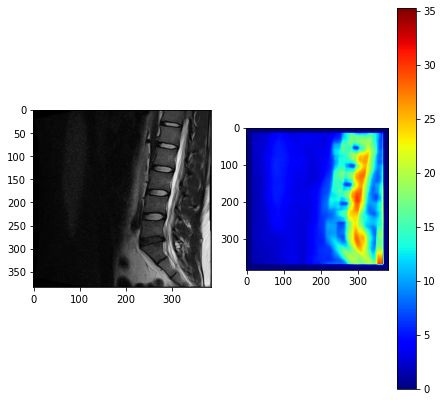

In [82]:
box_filtered_3d = box_filtering3d_with_gauss(object_3d, degree=1.8, size=(1,15,15), sigma=1, alpha=0)[6]


fig, ax = plt.subplots(ncols=2, figsize=(7,7))

im1 = ax[0].imshow(object_3d[6], cmap='gray')
im2 = ax[1].imshow(box_filtered_3d, cmap='jet')

fig.colorbar(im2, ax=ax[1])

147456